In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [15]:
# Se descargan imágenes (32x32 píxeles, 3 canales RGB)
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [16]:
# Normalizar pixeles (0 a 1)
train_images = train_images / 255.0
test_images = test_images / 255.0

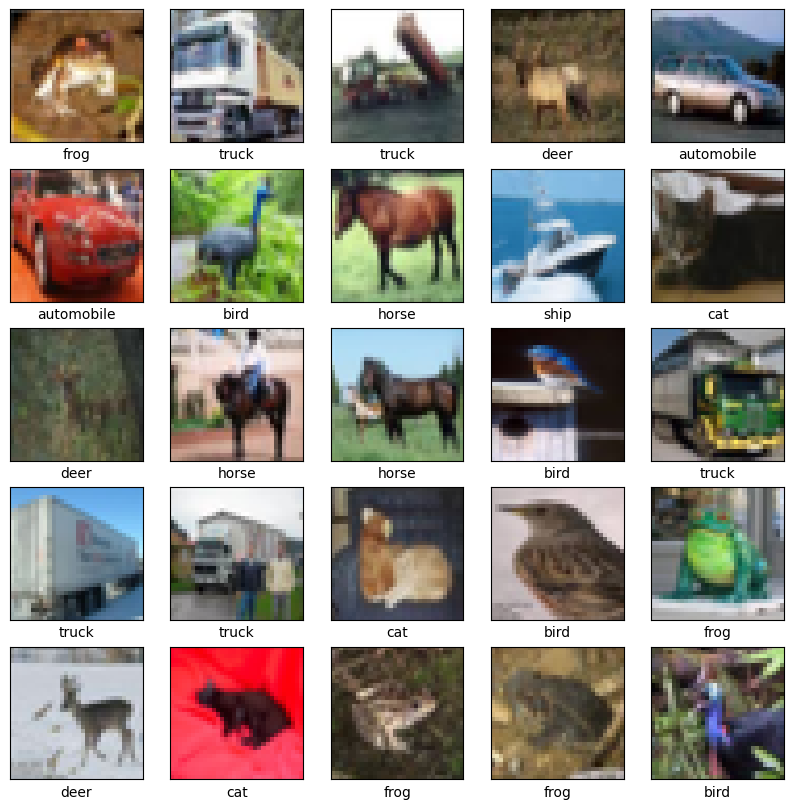

In [17]:
# Etiquetas de clases y visualización
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Mostrar 25 imágenes con su etiqueta
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([]); plt.yticks([]); plt.grid(False)
  plt.imshow(train_images[i])
  plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [18]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

In [19]:
# Definir la red neuronal convolucional
model = models.Sequential()

# Primera capa convolucional: 32 filtros, tamaño 3x3, activación relu
# Se define input_shape=(32,32,3) por el tamaño de las imágenes RGB
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))  # Agrupación reduce dimensionalidad

# Segunda capa convolucional
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Tercera capa convolucional
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())     # Aplana tensor 3D a vector 1D
model.add(layers.Dense(128, activation='relu'))  # Capa oculta
model.add(layers.Dropout(0.4))  # Apaga el 40% de las neuronas aleatoriamente
model.add(layers.Dense(10))  # Capa de salida: 10 clases

# Mostrar resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
# Compilar modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [21]:
# Callbacks para mejorar entrenamiento
earlystop = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [22]:
# Entrenamiento
EPOCHS = 50
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=EPOCHS,
                    validation_data=(test_images, test_labels),
                    callbacks=[earlystop, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3318 - loss: 2.1536 - val_accuracy: 0.5418 - val_loss: 1.3162 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.5132 - loss: 1.3703 - val_accuracy: 0.5313 - val_loss: 1.2812 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5573 - loss: 1.2367 - val_accuracy: 0.5730 - val_loss: 1.2507 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.5963 - loss: 1.1437 - val_accuracy: 0.6116 - val_loss: 1.1172 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.6209 - loss: 1.0767 - val_accuracy: 0.6712 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.6376 - loss: 1.0312 - val_accuracy: 0.5941 - val_loss: 1.2520 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6576 - loss: 0.9955

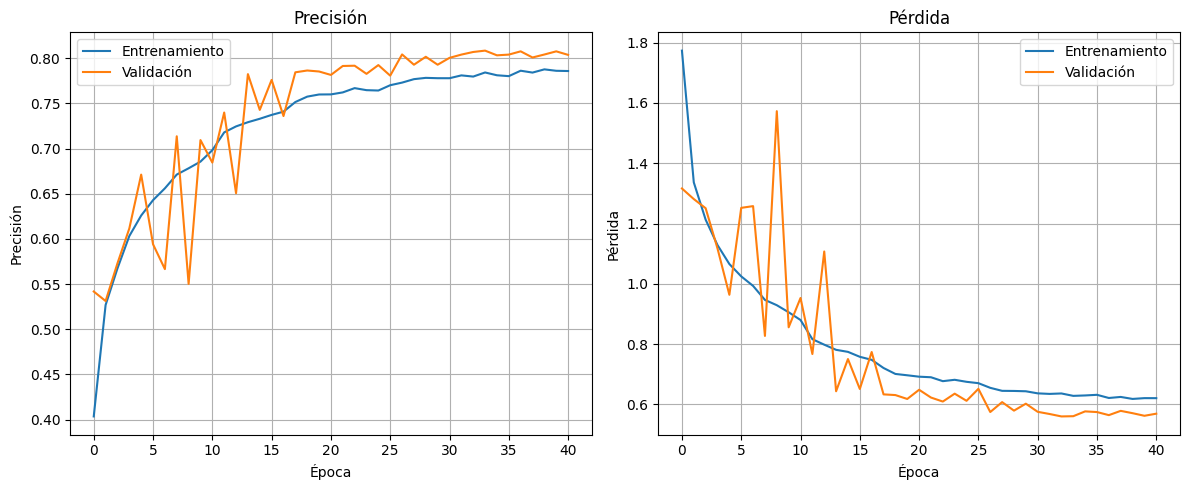

In [23]:
# Visualización de precisión y pérdida
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Época'); plt.ylabel('Precisión')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Época'); plt.ylabel('Pérdida')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


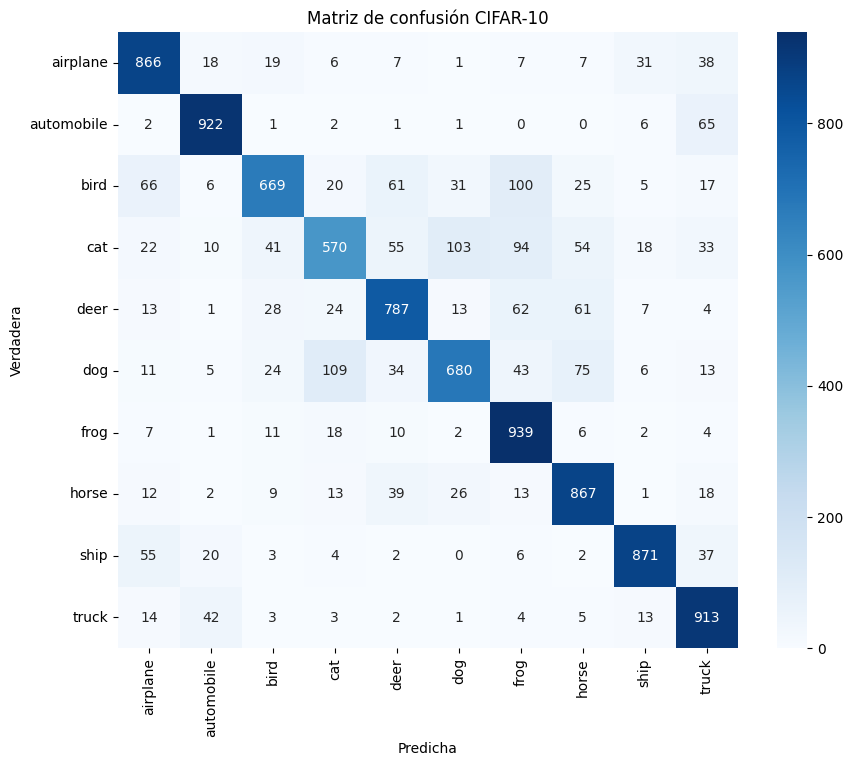

In [24]:
# Matriz de confusión
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
y_true = test_labels.flatten()

cf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicha"); plt.ylabel("Verdadera")
plt.title("Matriz de confusión CIFAR-10")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


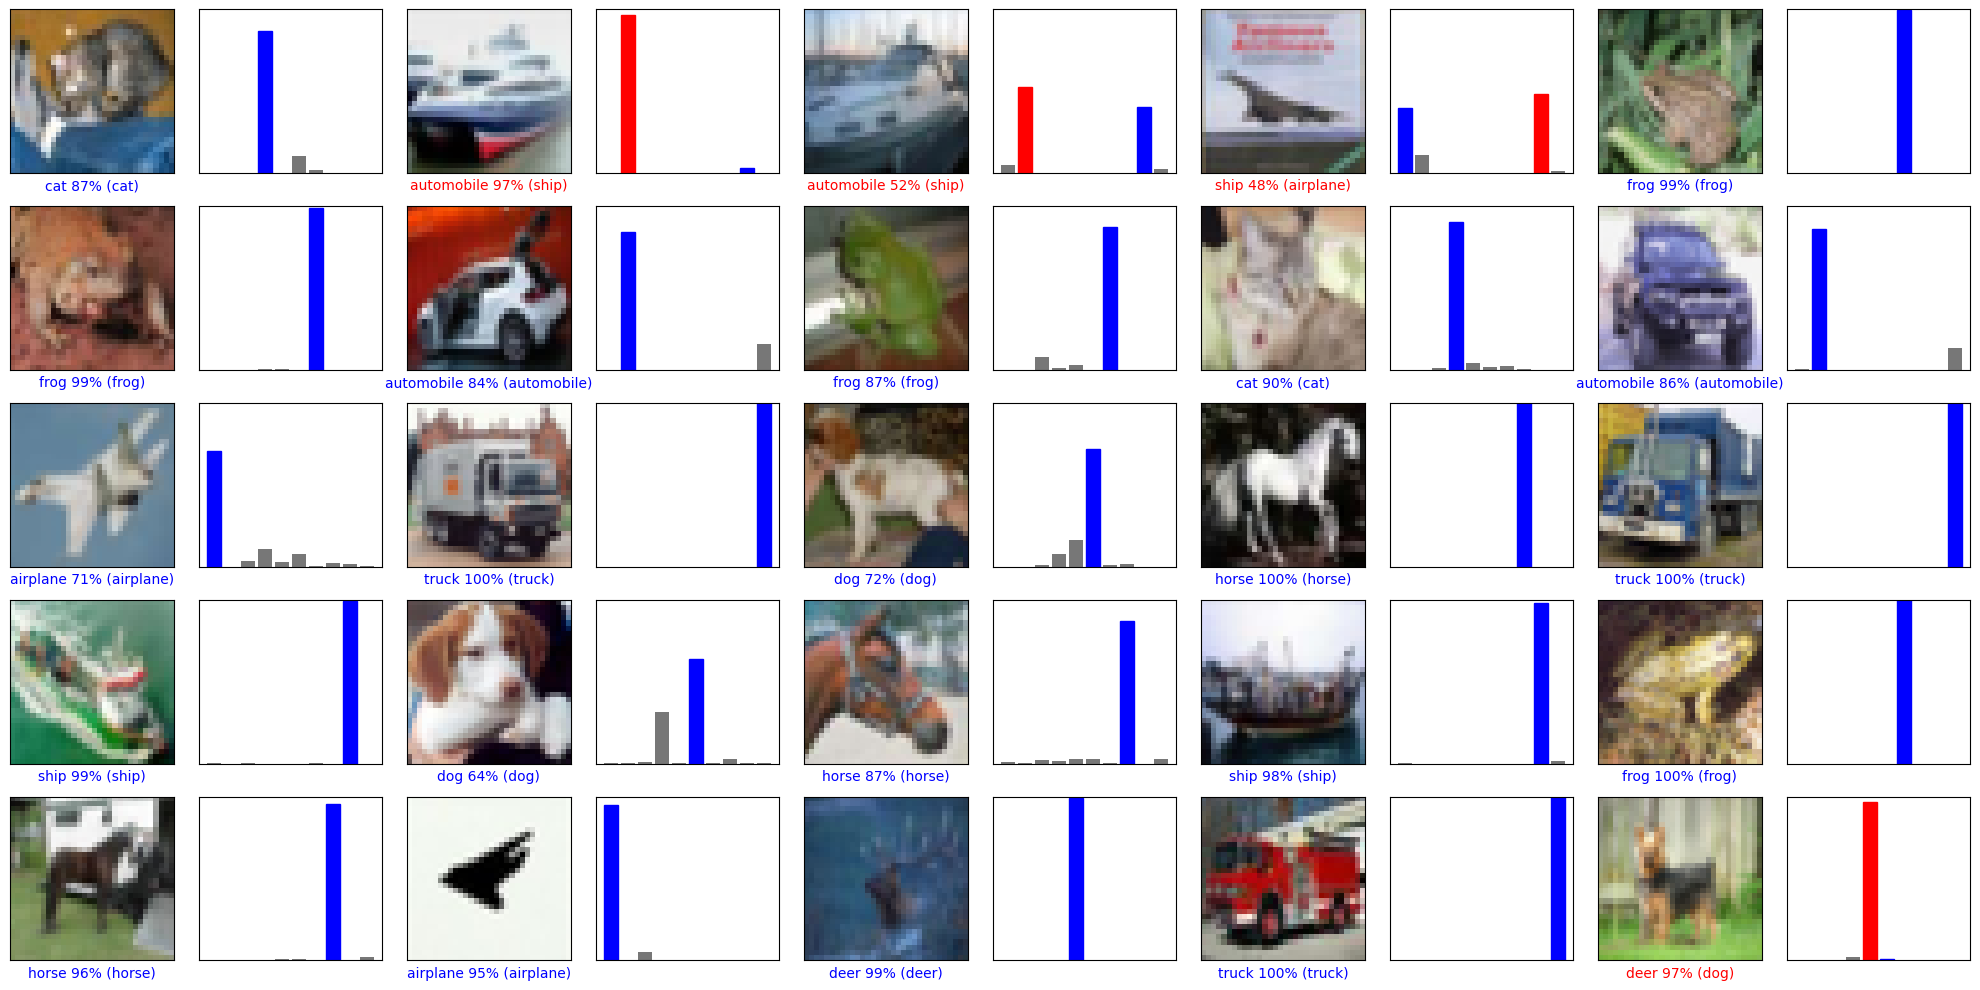

In [25]:
# Selección de imágenes y predicciones (primeras 100 del set de prueba)
imagenes_prueba = test_images[:100]
etiquetas_prueba = test_labels[:100].flatten()  # Pasamos de matriz a vector
predicciones = probability_model.predict(imagenes_prueba)

# Función que grafica la imagen con predicción (azul si es correcta, rojo si no)
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  color = 'blue' if etiqueta_prediccion == etiqueta_real else 'red'

  plt.xlabel(f"{class_names[etiqueta_prediccion]} {100*np.max(arr_predicciones):.0f}% ({class_names[etiqueta_real]})", color=color)

# Función que grafica la barra de probabilidades para cada clase
def graficar_valor_arreglo(i, arr_predicciones, etiquetas_reales):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiquetas_reales[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

# Mostrar una grilla de 25 imágenes con sus barras de predicción
filas = 5
columnas = 5
num_imagenes = filas * columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
plt.tight_layout()
plt.show()

In [26]:
# Mostrar precisión final
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"\nPrecisión final en el set de prueba: {test_acc:.4f}")

313/313 - 1s - 2ms/step - accuracy: 0.8084 - loss: 0.5606

Precisión final en el set de prueba: 0.8084


## Resumen
En este proyecto se desarrolló un modelo de red neuronal convolucional (CNN) con TensorFlow/Keras para clasificar imágenes del conjunto de datos CIFAR-10. El flujo de trabajo incluyó:

1. Importación de bibliotecas clave para procesamiento, visualización y métricas.

2. Carga y normalización del dataset, preparando las imágenes para acelerar el entrenamiento.

3. Visualización exploratoria, graficando ejemplos de cada clase.

4. Diseño del modelo CNN, incorporando capas Conv2D, MaxPooling2D, BatchNormalization, Dropout y Dense.

5. Entrenamiento con data augmentation, early stopping y reducción del learning rate, logrando estabilizar y mejorar el aprendizaje.

6. Evaluación del rendimiento, con gráficos de pérdida y precisión y matriz de confusión para identificar fortalezas y debilidades.

7. Visualización de predicciones, mostrando tanto aciertos como errores con sus probabilidades.

El modelo alcanzó un 80% de precisión en el conjunto de prueba, consolidándose como una solución efectiva para la clasificación automática de imágenes en problemas similares.

##  Conclusión

El modelo CNN desarrollado mostró un rendimiento sólido en la tarea de clasificación de imágenes del dataset CIFAR-10, alcanzando una precisión cercana al 80% en el conjunto de prueba. Esto se logró gracias a la incorporación de técnicas avanzadas como data augmentation, batch normalization, Dropout, EarlyStopping y reducción automática del learning rate, que permitieron mejorar la capacidad de generalización del modelo y reducir el sobreajuste.

Las gráficas de pérdida y precisión, junto con la matriz de confusión, evidenciaron tanto los aciertos como las confusiones entre clases visualmente similares (por ejemplo, gato vs. perro), brindando una visión completa del desempeño del modelo.

Este trabajo demuestra la eficacia de las redes neuronales convolucionales para abordar problemas de clasificación de imágenes de complejidad intermedia, y sirve como base para futuros desarrollos que podrían incluir la exploración de arquitecturas más profundas como ResNet o VGG, o la optimización de hiperparámetros para seguir incrementando la precisión.

